Using Principal Component Analysis (PCA)

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.6 MB/s eta 0:00:00


Data Preprocessing

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

# Function to load data from various formats
def load_data(file_path, file_format='csv'):
    if file_format == 'csv':
        df = pd.read_csv(file_path)
    elif file_format == 'json':
        df = pd.read_json(file_path)
    elif file_format == 'xlsx':
        df = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Please use 'csv', 'json', or 'xlsx'.")
    return df

# Function to preprocess time-series data
def preprocess_timeseries_data(df, target_variable):
    df_features = df.drop(columns=[target_variable])

    # Identify datetime columns
    datetime_cols = df_features.select_dtypes(include=['datetime64', 'object']).columns.tolist()

    # Convert datetime columns to datetime dtype if they are not already
    for col in datetime_cols:
        try:
            df_features[col] = pd.to_datetime(df_features[col])
        except Exception as e:
            print(f"Error converting {col} to datetime: {e}")
            continue

    # Drop datetime columns from features (or convert to numeric features if relevant)
    df_features = df_features.drop(columns=datetime_cols)

    # Handle missing values (for numeric data)
    df_features = df_features.fillna(df_features.median())

    # Handle categorical variables
    categorical_cols = df_features.select_dtypes(include=[object, 'category']).columns.tolist()
    if len(categorical_cols) > 0:
        encoder = OneHotEncoder(drop='first', sparse=False)
        df_encoded = encoder.fit_transform(df_features[categorical_cols])
        df_features = df_features.drop(columns=categorical_cols)
        df_features = pd.concat([df_features, pd.DataFrame(df_encoded, columns=encoder.get_feature_names_out(categorical_cols))], axis=1)

    # Scale numeric features
    scaler = StandardScaler()
    df_features_scaled = scaler.fit_transform(df_features.select_dtypes(include=[np.number]))

    return df_features_scaled

# Function to perform PCA on time-series data
def perform_pca(df):
    pca = PCA()
    pca.fit(df)
    explained_variance_ratio = pca.explained_variance_ratio_
    return explained_variance_ratio, pca

# Function to plot Scree plot
def plot_scree(explained_variance_ratio):
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.grid()
    plt.show()

Model Development and Evaluation

Error converting datetime to datetime: time data "13-01-2015 00:00" doesn't match format "%m-%d-%Y %H:%M", at position 239. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.


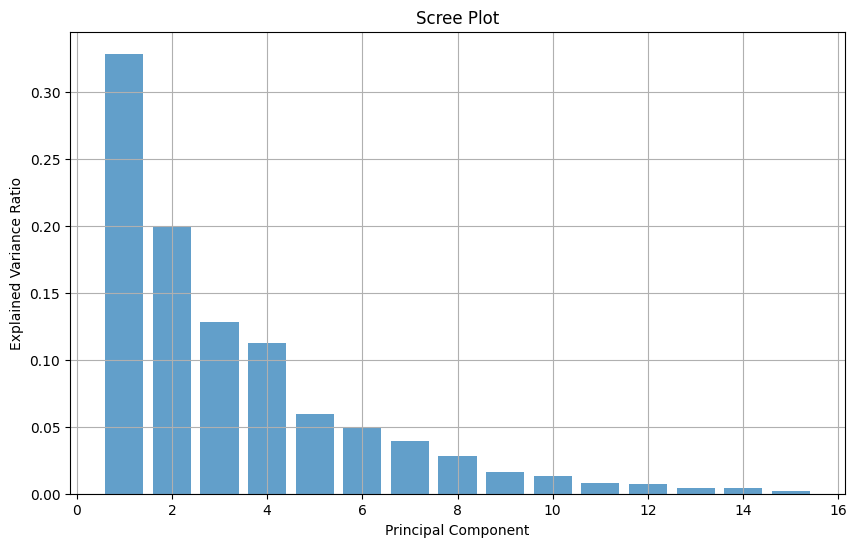


Total Variance Explained by PCA: 1.0000

Model Evaluation Results for Time-Series:
  Training time: 3.7319
  Mean Squared Error: 74215.1958
  R^2 Score: -0.9634
  Mean Absolute Error: 215.0251


In [7]:
# Function to evaluate ARIMA model
def evaluate_arima_model(X_train, X_test, y_train, y_test, order):
    model = ARIMA(y_train, order=order)
    start_time = time.time()
    model_fit = model.fit()
    training_time = time.time() - start_time
    y_pred = model_fit.forecast(steps=len(y_test))
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    results = {
        'Training time': training_time,
        'Mean Squared Error': mse,
        'R^2 Score': r2,
        'Mean Absolute Error': mae
    }

    return results

# Load the dataset
file_path = 'train.csv'  # Update with your file path
file_format = 'csv'
target_variable = 'nat_demand'

df = load_data(file_path, file_format)

# Preprocess data
df_features_scaled = preprocess_timeseries_data(df, target_variable)
X = df_features_scaled
y = df[target_variable].values

# PCA analysis
explained_variance_ratio, pca = perform_pca(df_features_scaled)
plot_scree(explained_variance_ratio)
total_variance = explained_variance_ratio.cumsum()[-1]
print(f"\nTotal Variance Explained by PCA: {total_variance:.4f}")

# Split data and evaluate model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
order = (5, 1, 0)  # Example ARIMA order
evaluation_results = evaluate_arima_model(X_train, X_test, y_train, y_test, order)

# Print evaluation results
print("\nModel Evaluation Results for Time-Series:")
for metric_name, value in evaluation_results.items():
    print(f"  {metric_name}: {value:.4f}")

In [6]:
import json

def process_chunk(chunk):
    """
    Process a chunk of text to extract and print JSON keys.
    """
    try:
        data = json.loads(chunk)
        if isinstance(data, dict):
            print("Keys in JSON object:")
            for key in data.keys():
                print(key)
        elif isinstance(data, list):
            if len(data) > 0 and isinstance(data[0], dict):
                print("Keys in JSON object (first dictionary):")
                for key in data[0].keys():
                    print(key)
            else:
                print("Chunk does not contain dictionaries.")
        else:
            print("Chunk is neither a dictionary nor a list of dictionaries.")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON chunk: {e}")

def read_large_json(file_path, chunk_size=1024*1024):
    """
    Read a large JSON file in chunks and process each chunk.
    """
    with open(file_path, 'r') as file:
        buffer = ""
        while True:
            chunk = file.read(chunk_size)
            if not chunk:
                break
            buffer += chunk
            while '\n' in buffer:
                line, buffer = buffer.split('\n', 1)
                process_chunk(line)
        # Process any remaining data in the buffer
        if buffer:
            process_chunk(buffer)

# File path to your JSON file
file_path = 'wikivital_mathematics.json'
read_large_json(file_path)


Error decoding JSON chunk: Extra data: line 1 column 3288303 (char 3288302)


In [10]:
!pip install ijson
import ijson

def print_keys_from_json(file_path):
    """
    Print keys from a large JSON file using streaming JSON parser.
    """
    with open(file_path, 'r') as file:
        parser = ijson.parse(file)
        for prefix, event, value in parser:
            if event == 'map_key':
                print(f"Key: {value}")

# File path to your JSON file
file_path = 'wikivital_mathematics.json'
print_keys_from_json(file_path)

Key: edges
Key: weights
Key: node_ids
Key: Mathematics
Key: Mathematician
Key: Applied mathematics
Key: Pure mathematics
Key: Recreational mathematics
Key: Arithmetic
Key: Counting
Key: Cardinal number
Key: Tally marks
Key: Addition
Key: Plus and minus signs
Key: Subtraction
Key: Multiplication
Key: Multiplication sign
Key: Division (mathematics)
Key: Division sign
Key: Euclidean algorithm
Key: Long division
Key: Division by zero
Key: Divisibility rule
Key: Fraction
Key: Percentage
Key: Percent sign
Key: Continued fraction
Key: Egyptian fraction
Key: Modular arithmetic
Key: Modulo operation
Key: Divisor
Key: Greatest common divisor
Key: Lowest common denominator
Key: Multiple (mathematics)
Key: Least common multiple
Key: Number
Key: Natural number
Key: Integer
Key: Parity (mathematics)
Key: Real number
Key: Negative number
Key: Sign (mathematics)
Key: Complex number
Key: Gaussian integer
Key: Rational number
Key: Irrational number
Key: Imaginary number
Key: Algebraic number
Key: Transc

IncompleteJSONError: parse error: trailing garbage
          94, 10, 5, 11, 47, 26, 706]}}, 963, 208, 211, 988, 10, 468, 
                     (right here) ------^
